### Agent-Based Modelling - FS19
# ABM Final - Gabriela Lopez & Luca Weibel



Here are the libraries / configurations used.

In [192]:
%config IPCompleter.greedy=True

import networkx as nx
import numpy as np
import numpy.random as rnd
import collections
import math as m
from prettytable import PrettyTable
import copy

import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [193]:
class Shift():
    def __init__(self, day, shift_num, num_nurses_needed):
        self.day = day
        self.shift_num = shift_num
        self.num_nurses_needed = num_nurses_needed
        self.nurses = []
        
    def get_id_tuple(self):
        return (self.day, self.shift_num)
    
    def get_list_of_nurses_names(self):
        return [n.id_name for n in self.nurses]

In [262]:
class Schedule():
    num_shifts_per_day = 3
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    
    def __init__(self, num_nurses_needed, is_random=False):
        self.num_nurses_needed = num_nurses_needed
        self.is_random = is_random
        self.schedule = []
        for day in self.days:
            for shift_num in range(self.num_shifts_per_day):
                num_needed = rnd.randint(self.num_nurses_needed + 1) if is_random else self.num_nurses_needed
                self.schedule.append(Shift(day, shift_num + 1, num_needed))
                
    def get_shift_coverage(self):
        total_shifts = 0
        filled_shifts = 0
        for shift in self.schedule:
            total_shifts += shift.num_nurses_needed
            filled_shifts += min(len(shift.nurses), shift.num_nurses_needed)
        return filled_shifts / total_shifts
    
    def add_nurse_to_shift(self, nurse, shift_preference, add_to_nurse):
        idx_in_schedule = self.days.index(shift_preference[0]) * 3 + (shift_preference[1] - 1)
        self.schedule[idx_in_schedule].nurses.append(nurse)
        if add_to_nurse: nurse.shifts.append(shift_preference)
            
    def remove_nurse_from_shift(self, nurse, shift_preference, remove_from_nurse):
        idx_in_schedule = self.days.index(shift_preference[0]) * 3 + (shift_preference[1] - 1)
        for idx, n in enumerate(self.schedule[idx_in_schedule].nurses):
            if n.id_name == nurse.id_name:
                self.schedule[idx_in_schedule].nurses.pop(idx)
        if remove_from_nurse: nurse.shifts.remove(shift_preference)
        
    def get_utility(self, beta=1):
        utility = 0
        nurses_assigned_per_day = {day: [] for day in self.days}
        nurses_days_working = {}
        # evaluating shift capacity (no overbooking shifts)
        for shift in self.schedule:
            if len(shift.nurses) > shift.num_nurses_needed:
                utility -= 50000
            else:
                utility += len(shift.nurses) * 10
            nurses_assigned_per_day[shift.day] += shift.get_list_of_nurses_names()
        # evaluating if multiple shifts on the same day (employees can work max one shift per day)
        for day in nurses_assigned_per_day:
            counts = collections.Counter(nurses_assigned_per_day[day])
            for nurse in counts:
                if counts[nurse] > 1:
                    utility -= 5000
                if nurse in nurses_days_working:
                    nurses_days_working[nurse].append(1)
                else:
                    nurses_days_working[nurse] = [1]
        # evaluating continuous days working (employees cannot work for more than 6 days continuously)
        for nurse in nurses_days_working:
            if len(nurses_days_working[nurse]) >= 7:
                utility -= 5000
        utility *= beta
        return utility
    
    def print_filled_in_schedule(self, schedule_strs, title=''):
        t = PrettyTable([''] + self.days)
        t.align = 'l'
        for i in range(self.num_shifts_per_day):
            t.add_row([f'shift {i + 1}'] + schedule_strs[i::self.num_shifts_per_day])
        print(title)
        print(t)
                
    def print_schedule(self):
        schedule_strs = []
        for shift in self.schedule:
            nurses_str = ''
            for idx, n in enumerate(shift.get_list_of_nurses_names()):
                if idx % 4 == 0:
                    nurses_str += '\n'
                nurses_str += str(n)
                if idx != len(shift.get_list_of_nurses_names()) - 1:
                    nurses_str += ','
            schedule_strs.append( 
                f"need: {shift.num_nurses_needed}\n"
                f"nurses: {nurses_str}"
            )
        self.print_filled_in_schedule(schedule_strs, title="Week's Schedule")

In [195]:
class Nurse():
    def __init__(self, id_name):
        self.id_name = id_name
        self.shift_preferences = []
        self.shifts = []
        
    def generate_shift_preferences(self, degree_of_agent_availability, works_weekends):
        schedule = Schedule(0)
        for shift in schedule.schedule:
            if not works_weekends and shift.day in schedule.days[-2:]:
                continue
            if rnd.uniform() < degree_of_agent_availability:
                self.shift_preferences.append((shift.day, shift.shift_num))
    
    def print_shift_preferences(self):
        schedule = Schedule(0)
        schedule_strs = []
        for shift in schedule.schedule:
            if shift.get_id_tuple() in self.shift_preferences:
                schedule_strs.append('x')
            else:
                schedule_strs.append(' ')
        schedule.print_filled_in_schedule(schedule_strs, title=f"Nurse {self.id_name}'s Preferences")

In [196]:
def generate_nurses(num_nurses, degree_of_agent_availability, works_weekends):
    nurses = []
    for n in range(num_nurses):
        nurse = Nurse(id_name=n)
        nurse.generate_shift_preferences(degree_of_agent_availability, works_weekends)
        nurses.append(nurse)
    return nurses

Week's Schedule
+---------+----------+----------+-----------+----------+----------+----------+----------+
|         | monday   | tuesday  | wednesday | thursday | friday   | saturday | sunday   |
+---------+----------+----------+-----------+----------+----------+----------+----------+
| shift 1 | need: 3  | need: 3  | need: 3   | need: 3  | need: 3  | need: 3  | need: 3  |
|         | nurses:  | nurses:  | nurses:   | nurses:  | nurses:  | nurses:  | nurses:  |
| shift 2 | need: 3  | need: 3  | need: 3   | need: 3  | need: 3  | need: 3  | need: 3  |
|         | nurses:  | nurses:  | nurses:   | nurses:  | nurses:  | nurses:  | nurses:  |
| shift 3 | need: 3  | need: 3  | need: 3   | need: 3  | need: 3  | need: 3  | need: 3  |
|         | nurses:  | nurses:  | nurses:   | nurses:  | nurses:  | nurses:  | nurses:  |
+---------+----------+----------+-----------+----------+----------+----------+----------+
Week's Schedule
+---------+----------+----------+-----------+----------+----------+-

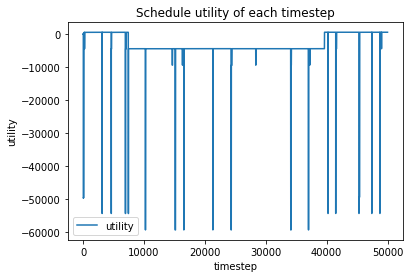

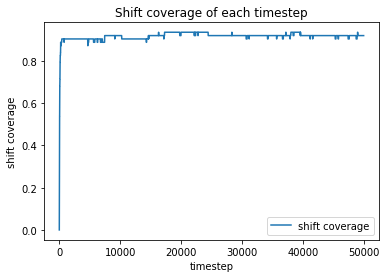

In [269]:
schedule = Schedule(num_nurses_needed=3)
candidate_schedule = copy.deepcopy(schedule)
nurses = generate_nurses(10, 0.5, True)
p_to_accept_negative_change = .001
# show what all shift preferences look like in the schedule
hypothetical_max_schedule = copy.deepcopy(schedule)
for nurse in nurses:
    for shift in nurse.shift_preferences:
        hypothetical_max_schedule.add_nurse_to_shift(nurse, shift, False)
        
schedule.print_schedule()
hypothetical_max_schedule.print_schedule()
print('Crude hypothetical shift coverage:', hypothetical_max_schedule.get_shift_coverage())

utility_each_timestep = []
shift_coverage_each_timestep = []
# timestep is for each nurse, so total timesteps = x * num_nurses where x is range(x)
for timestep in range(5000):
    for nurse in nurses:
        schedule_utility = schedule.get_utility()
        utility_each_timestep.append(schedule_utility)
        shift_coverage_each_timestep.append(schedule.get_shift_coverage())
        rnd_i = rnd.randint(len(nurse.shift_preferences))
        rnd_shift_pref = nurse.shift_preferences[rnd_i]
        was_in_shift = rnd_shift_pref in nurse.shifts
        # try adding/removing shift depending on whether the shift is assigned
        if not was_in_shift:
            candidate_schedule.add_nurse_to_shift(nurse, rnd_shift_pref, False)
        else:
            candidate_schedule.remove_nurse_from_shift(nurse, rnd_shift_pref, False)
        # if the change was better or randomly accept negative change, apply change to schedule
        if (candidate_schedule.get_utility() > schedule_utility) or (rnd.random_sample() < p_to_accept_negative_change):
            if not was_in_shift:
                schedule.add_nurse_to_shift(nurse, rnd_shift_pref, True)
            else:
                schedule.remove_nurse_from_shift(nurse, rnd_shift_pref, True)
        # if the change was worse, undo the change to the candidate schedule
        else:
            if not was_in_shift:
                candidate_schedule.remove_nurse_from_shift(nurse, rnd_shift_pref, False)
            else:
                candidate_schedule.add_nurse_to_shift(nurse, rnd_shift_pref, False)

schedule.print_schedule()
print('Solution shift coverage:',schedule.get_shift_coverage())

plt.figure()
plt.plot(utility_each_timestep, label = "utility")
plt.title("Schedule utility of each timestep")
plt.xlabel("timestep")
plt.ylabel("utility")
plt.legend()
plt.show()

plt.figure()
plt.plot(shift_coverage_each_timestep, label = "shift coverage")
plt.title("Shift coverage of each timestep")
plt.xlabel("timestep")
plt.ylabel("shift coverage")
plt.legend()
plt.show()